$$\require{mhchem}$$
# Overlaying optical and mass spectrometry imaging datasets using OpenMSI and IPython

## Preliminaries: importing required Python modules, providing paths to data

In [1]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

# NumPy
import numpy as np

# Downloading json from the web and parsing into Python
import ast
import json
import requests

# Image manipulation
from scipy.misc import imread, imresize, imrotate
from scipy import ndimage
import imreg_dft as ird
from sklearn import decomposition
from skimage import exposure

## Reading MSI data into IPython using OpenMSI's web API

In [2]:
# file and hdf5 path parameters

MS1_DATA_INDEX = 1  # this is true for this file but not in general
EXP_INDEX = 0
MSI_FILEPATH = '/data/openmsi/omsi_data/lung_orbitrap.h5'

# starting a session:

client = requests.Session()

def get_image_size(msi_filepath, data_index):
    """Simple helper function that returns tuple of datacube dimensions"""
    # Assemble qmetadata parameters
    payload = {'file': msi_filepath, 
               'format': 'JSON', 
               'mtype': 'file',
               'expIndex': EXP_INDEX, 
               'dataIndex': data_index,
              }
    
    # form qmetadata request
    url = 'https://openmsi.nersc.gov/openmsi/qmetadata'
    r = client.get(url,params=payload)
    
    # parse metadata
    metadata = json.loads(r.content)
    image_size = ast.literal_eval(metadata[u'children'][0][u'shape'])
    return image_size

# print the size of each MSI image
print get_image_size(msi_filepath=MSI_FILEPATH, data_index = '0') 


(132, 149, 500000)


In [3]:
def load_mz_axis(msi_filepath, data_index):
    """Simple helper function that returns a numpy.ndarray with the mz axis of an OpenMSI dataset"""
    # assemble qmz parameters
    payload = {'file': msi_filepath,
               'expIndex': EXP_INDEX, 
               'dataIndex': data_index,
               'qspectrum_viewerOption': '0',
               'qslice_viewerOption': '0',
               'col': 0, 
               'row': 0,
               'findPeak':'0',
               'format':'JSON',
              }
    
    # form qmz request
    url = 'https://openmsi.nersc.gov/openmsi/qmz'
    r = client.get(url, params=payload)
    data = json.loads(r.content)
    
    mz = np.asarray(data[u'values_spectra'])
    return mz

# get the mz axis for each datacube:

mz_axis = load_mz_axis(msi_filepath=MSI_FILEPATH, data_index='0') 

print mz_axis

[  349.90176392   349.90298462   349.90420532 ...,  2008.56274414
  2008.56970215  2008.57678223]


In [4]:
def load_ion_image(msi_filepath, data_index, ion_mz, mz_tol):
    """Simple helper function that loads a requested m/z image"""
    
    # finding indices of mz_axis within tolerance of desired ion
    mz_idx = np.where(np.abs(mz_axis - ion_mz) < mz_tol)[0]
    
    # qslice parameters
    payload = {'file': msi_filepath, 
               'format': 'JSON',
               'mtype': 'file', 
               'expIndex': EXP_INDEX, 
               'dataIndex': data_index,
               'mz':'%d:%d' % (mz_idx.min(), mz_idx.max()),
               }
    
    # form qslice request
    url = 'https://openmsi.nersc.gov/openmsi/qslice'
    client = requests.Session()
    r = client.get(url, params=payload) 
    
    # getting image data
    r = client.get(url, params=payload)
    image = np.asarray(json.loads(r.content))
    return image


my_ions = [526.33, 692.334, 756.55]
my_images = [load_ion_image(MSI_FILEPATH, '0', ion_mz=ion, mz_tol=0.01) for ion in my_ions]

## Plotting the MS1 ion images

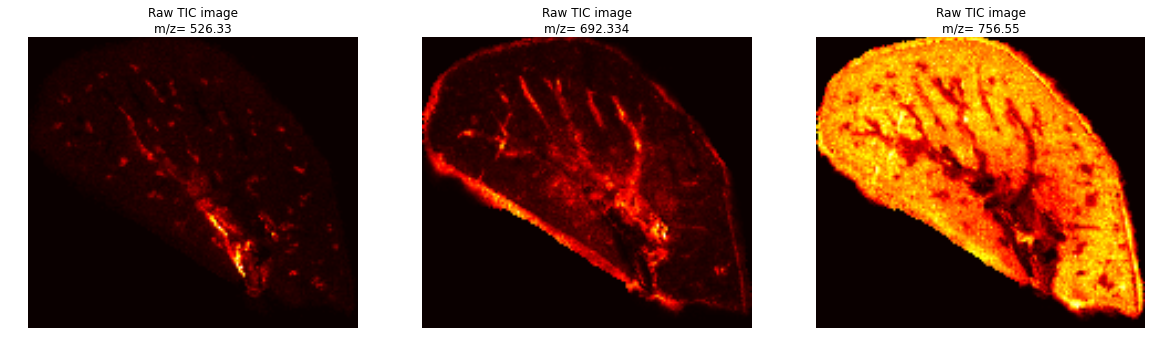

In [5]:
f, ax = plt.subplots(1, 3, figsize=(20, 10))

    
def plot_raw_image(ax, col_idx, image, label):
    ax[col_idx].imshow(image, cmap=cm.hot)
    ax[col_idx].set_axis_off()
    ax[col_idx].set_title("Raw TIC image\nm/z= %s" % label)

    return
    
for idx in xrange(3):
    plot_raw_image(ax, idx, my_images[idx], my_ions[idx])


## Importing an optical image into Python

In this example, we align an optical image with the MSI image.  Although this data is for a region of a spotted MALDI plate, in the future the same code could be applied to tissue images, such as histochemical iamges.  OpenMSI is not designed for storing optical images; thus in this example an image is loaded from a local file.  For you to use the code, you will need to obtain the image.

Optical image PC explained = [ 0.96776726  0.03072024  0.0015125 ]
Thus the monochrome optical image has 96.7767261596 of the 'signal' of the original RGB.


[<matplotlib.text.Text at 0x111783f50>, <matplotlib.text.Text at 0x1119f8e90>]

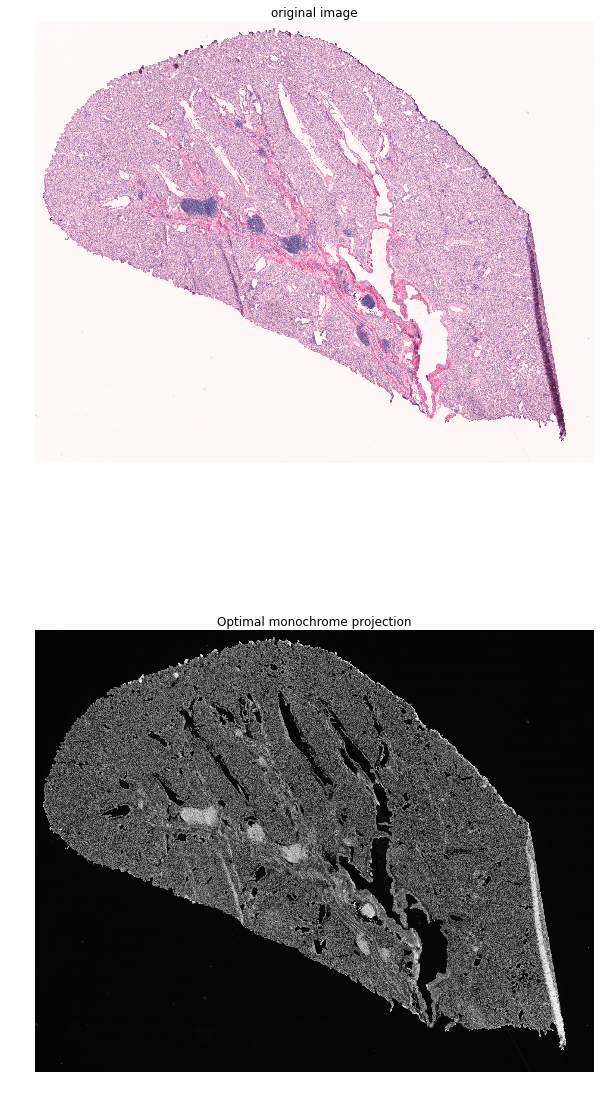

In [6]:
#grayscale image of plate:
optical_image = imread('/Users/curt/openMSI_localdata/LGU_075_9_slide4_H&E_10X_lung.png')



# doing PCA on the image to find the "best" monochrome representation
optical_flat = np.array([np.array(optical_image[:, :, i]).flatten() for i in range(optical_image.shape[2])]).T
pca = decomposition.PCA(n_components=3)
pca.fit(optical_flat.astype(float))
optical_pca_flat = pca.transform(optical_flat)
optical_monochrome = optical_pca_flat.reshape(optical_image.shape)[:, :, 0]

print "Optical image PC explained = %s" % pca.explained_variance_ratio_
print "Thus the monochrome optical image has %s of the 'signal' of the original RGB." % (pca.explained_variance_ratio_[0]*100)

# plot both images
f, ax = plt.subplots(2, 1, figsize=(10, 20))
ax[0].imshow(optical_image)
ax[1].imshow(optical_monochrome, cmap=cm.Greys_r)

# make the plots pretty
[axis.set_axis_off() for axis in ax]
titles = ['original image', 'Optimal monochrome projection']
[axis.set_title(title) for (axis, title) in zip(ax, titles)]

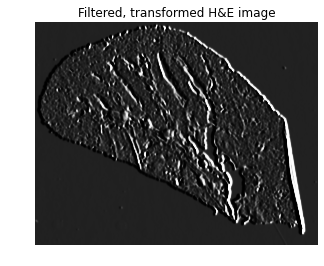

In [7]:
# do edge detection by sobel filter (after smoothing image to remove noise)
optical_blur = ndimage.filters.gaussian_filter(optical_monochrome, sigma=10, order=0)
optical_edges = ndimage.filters.sobel(optical_blur)

# enhance constrast in "edge" image
# the gain parameter in the sigmoid transformation was set through manual tuning
optical_edges_enhanced = exposure.adjust_sigmoid(exposure.rescale_intensity(optical_edges, 
                                                                    out_range=(0, 1)),
                                        gain=30, cutoff=0.45)

plt.imshow(optical_edges_enhanced, cmap=cm.Greys)
plt.title('Filtered, transformed H&E image')
plt.axes().set_axis_off()

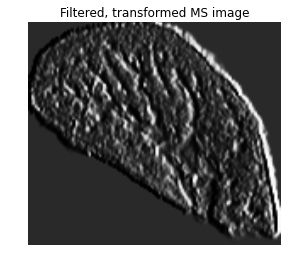

In [8]:
# do similar edge detection on MS image
ms_edges = ndimage.filters.sobel(my_images[2]).astype('float64')

# the gain parameter was made negative to make the MS image match the image above
ms_edges_enhanced =  exposure.adjust_sigmoid(exposure.rescale_intensity(ms_edges, 
                                                                out_range=(0, 1)),
                                            gain=-18, cutoff=0.42)

plt.imshow(ms_edges_enhanced, cmap=cm.Greys_r)
plt.title('Filtered, transformed MS image')
plt.axes().set_axis_off()

## Registration (i.e. matching & lining up) the optical image with one of our MS1 images.

With intensity-matched edge images for both H&E as well as a representative MS ion image, registration can proceed.  

Registration of MS image to H&E requires scaling by 0.944106494078
...and requires rotation by 1.20805369128 degrees
...and translation of 1, 0 pixels in (x, y)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


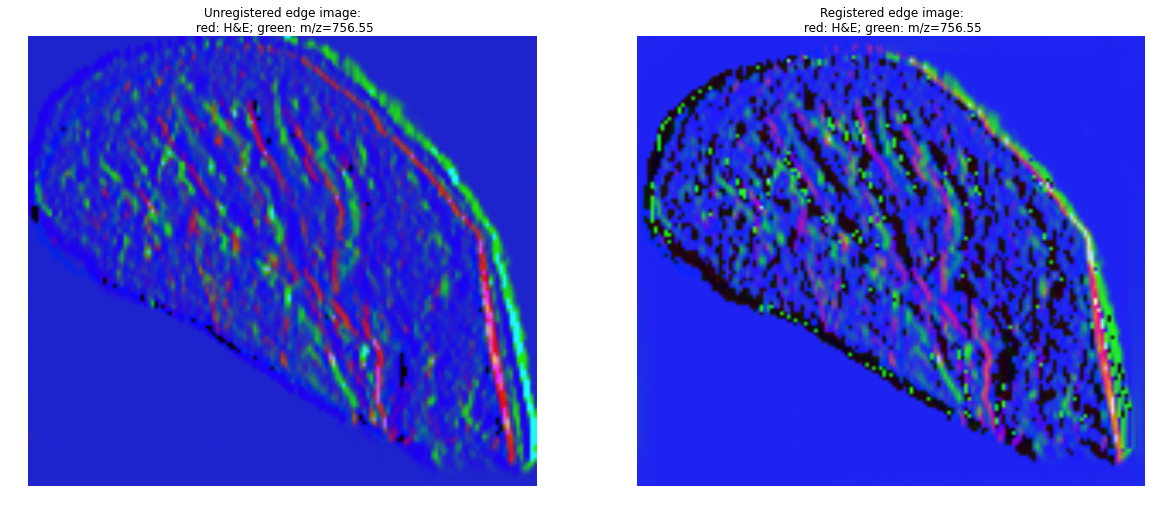

In [9]:
# downsample optical image
optical_small = imresize(optical_edges_enhanced, ms_edges_enhanced.shape)

# do constrained image registration
constraints = {'angle': [0, 5], 'scale': [1, 0.2], 'tx': [0, 5], 'ty': [0, 5]}
result = ird.similarity(optical_small, ms_edges_enhanced, constraints=constraints, numiter=20)

print 'Registration of MS image to H&E requires scaling by %s' % result['scale']
print '...and requires rotation by %s degrees' % result['angle']
print '...and translation of %s, %s pixels in (x, y)' % tuple(result['tvec'])

# make a high contrast overlay of optical in red and MS image in green or ORIGINAL image
diff_image = exposure.rescale_intensity(np.abs(ms_edges_enhanced - optical_small), out_range='uint8')
rgb_image = np.dstack((optical_small, ms_edges_enhanced, diff_image))

# make a high contrast overlay of optical in red and MS image in green or REGISTERED image
diff_image_reg = exposure.rescale_intensity(np.abs(result['timg'] - optical_small), out_range='uint8')
rgb_image_reg = np.dstack((optical_small, result['timg'], diff_image_reg))

# plot the registered and unregistered overlays side by side
f, ax = plt.subplots(1, 2, figsize=(20, 30))
images = [rgb_image, rgb_image_reg]
titles = ['Unregistered edge image:\n red: H&E; green: m/z=%s' % my_ions[2], 
          'Registered edge image:\n red: H&E; green: m/z=%s' % my_ions[2]]
for idx, ax_im_pair in enumerate(zip(ax, images)):
    axis, image = ax_im_pair[0], ax_im_pair[1]
    axis.imshow(image)
    axis.set_axis_off()
    axis.set_title(titles[idx])

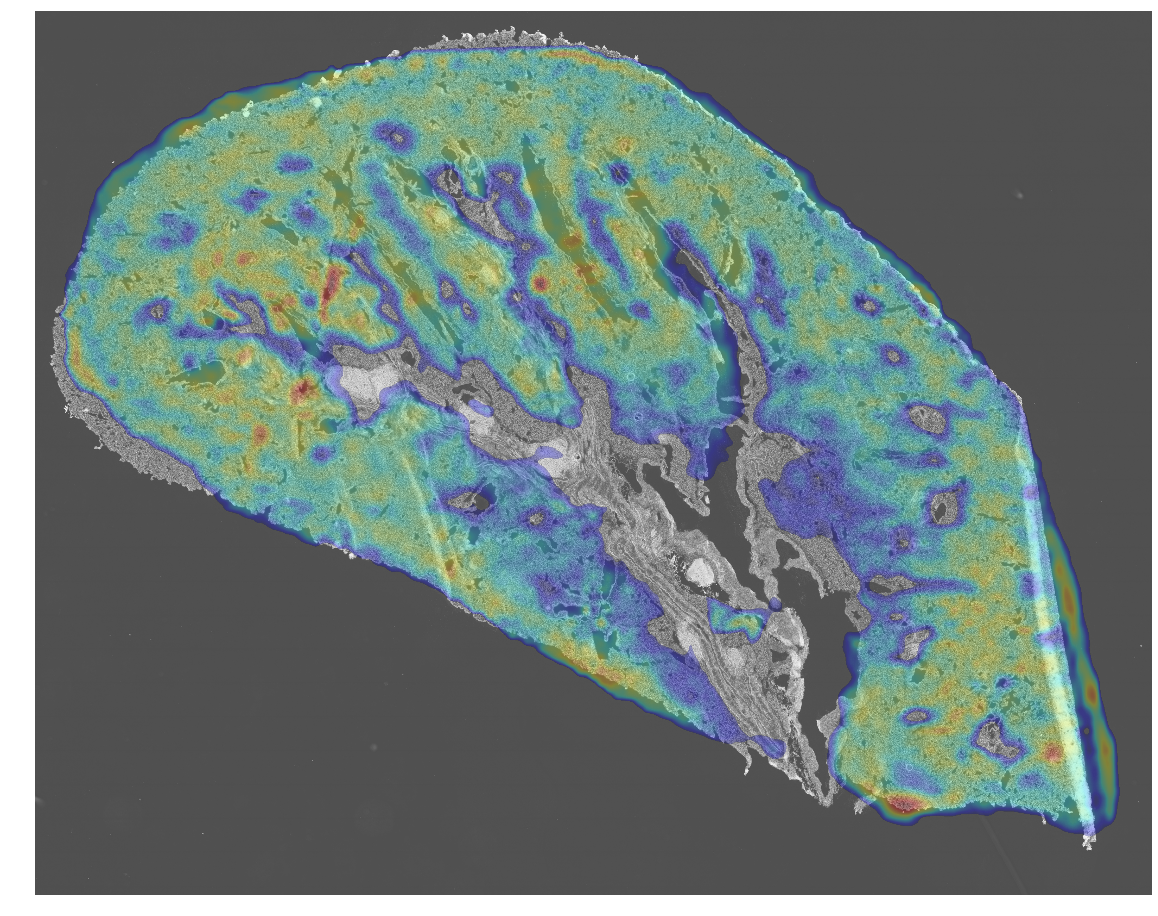

In [10]:
# overlaying the small H&E and MS images

registered_ms_image = ird.transform_img_dict(my_images[2], result)
big_registered_ms_image = imresize(registered_ms_image, optical_image.shape, interp='bicubic')

# cut out low intensity region of MS image for easy viewing of underlying H&E
masked_big_ms_image = np.ma.masked_where(big_registered_ms_image < 100, big_registered_ms_image)

# plot the two images overlayed
f = plt.figure(1, figsize=(20, 20))
plt.imshow(optical_monochrome, alpha=0.7, cmap=cm.Greys_r)
plt.imshow(masked_big_ms_image, alpha=0.3, cmap=cm.jet)
plt.axes().set_axis_off()